In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [2]:
tf.keras.__version__

'2.10.0'

In [3]:
# directories
# train_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
# test_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

train_img_path = 'artifact/train'
test_img_path = 'artifact/test'

w,h = 200,200
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 882752 images belonging to 2 classes.
Found 220694 images belonging to 2 classes.


In [4]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ResNET Transfer learning


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron (binary classification)
])

# Freeze the base model layers 
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 4s 0us/step


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


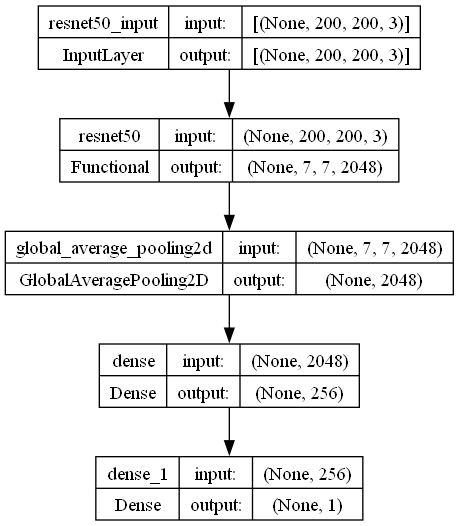

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [9]:
# Train the model
history = model.fit(train_Dataset, 
                    epochs=10, 
#                     callbacks=[model_checkpoint]
                   )

Epoch 1/10
27586/27586 [==============================] - 1681s 61ms/step - loss: 0.6278 - accuracy: 0.6334
Epoch 2/10
27586/27586 [==============================] - 1261s 46ms/step - loss: 0.6155 - accuracy: 0.6475
Epoch 3/10
27586/27586 [==============================] - 913s 33ms/step - loss: 0.6117 - accuracy: 0.6510
Epoch 4/10
27586/27586 [==============================] - 795s 29ms/step - loss: 0.6094 - accuracy: 0.6530
Epoch 5/10
27586/27586 [==============================] - 900s 33ms/step - loss: 0.6073 - accuracy: 0.6548
Epoch 6/10
27586/27586 [==============================] - 1023s 37ms/step - loss: 0.6060 - accuracy: 0.6561
Epoch 7/10
27586/27586 [==============================] - 835s 30ms/step - loss: 0.6047 - accuracy: 0.6573
Epoch 8/10
27586/27586 [==============================] - 838s 30ms/step - loss: 0.6036 - accuracy: 0.6580
Epoch 9/10
27586/27586 [==============================] - 950s 34ms/step - loss: 0.6024 - accuracy: 0.6590
Epoch 10/10
27586/27586 [=========

In [10]:
model.save('my_model_v3.keras')
model.save('my_model_v3.h5')

In [11]:
# load best weights to model
# model.load_weights(weight_path)
from sklearn.metrics import accuracy_score

# make prediction
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_Dataset.classes, binary_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')


6897/6897 [==============================] - 459s 66ms/step
Accuracy: 66.22%


# CNN Model

In [12]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)     

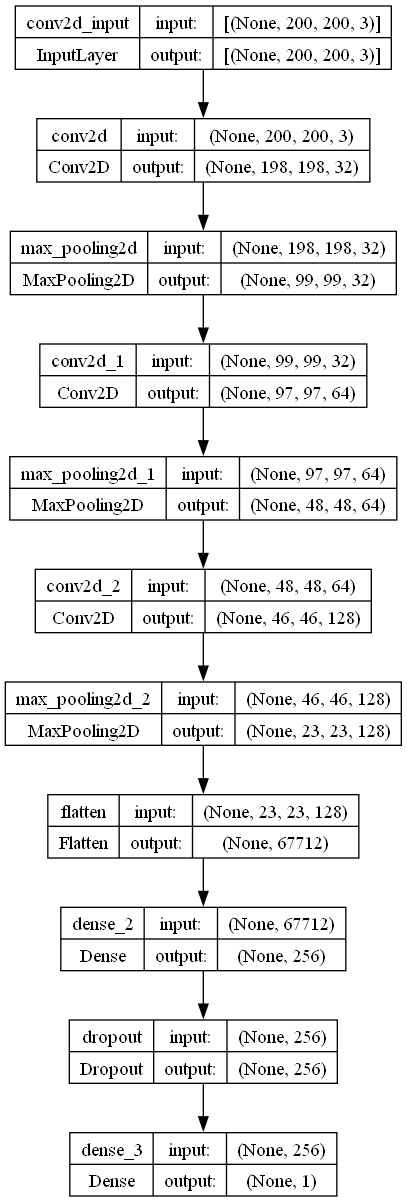

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)


# Run Model



In [14]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
history = model.fit(train_Dataset, 
                    epochs=10, 
#                     callbacks=[model_checkpoint]
                   )

Epoch 1/10
27586/27586 [==============================] - 1093s 40ms/step - loss: 0.5556 - accuracy: 0.6916
Epoch 2/10
27586/27586 [==============================] - 983s 36ms/step - loss: 0.5163 - accuracy: 0.7222
Epoch 3/10
27586/27586 [==============================] - 1033s 37ms/step - loss: 0.4979 - accuracy: 0.7356
Epoch 4/10
27586/27586 [==============================] - 898s 33ms/step - loss: 0.4870 - accuracy: 0.7436
Epoch 5/10
27586/27586 [==============================] - 900s 33ms/step - loss: 0.4799 - accuracy: 0.7477
Epoch 6/10
27586/27586 [==============================] - 857s 31ms/step - loss: 0.4749 - accuracy: 0.7508
Epoch 7/10
27586/27586 [==============================] - 899s 33ms/step - loss: 0.4707 - accuracy: 0.7537
Epoch 8/10
27586/27586 [==============================] - 836s 30ms/step - loss: 0.4673 - accuracy: 0.7559
Epoch 9/10
27586/27586 [==============================] - 840s 30ms/step - loss: 0.4647 - accuracy: 0.7574
Epoch 10/10
27586/27586 [==========

In [16]:
model.save_weights('./checkpoints/my_checkpoint')

In [17]:
model.save('my_model_v3.keras')
model.save('my_model_v3.h5')


In [18]:
# load best weights to model
# model.load_weights(weight_path)
from sklearn.metrics import accuracy_score

# make prediction
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_Dataset.classes, binary_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')


6897/6897 [==============================] - 335s 49ms/step
Accuracy: 74.82%


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
# sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual Classes')
# plt.show()

              precision    recall  f1-score   support

           0       0.71      0.66      0.69     90962
           1       0.77      0.81      0.79    129732

    accuracy                           0.75    220694
   macro avg       0.74      0.74      0.74    220694
weighted avg       0.75      0.75      0.75    220694

